# Интеллектуальный анализ данных – весна 2025
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.
* Если в задании есть вопрос на рассуждение, то за отсутствие ответа на него балл за задание будет снижен вполовину.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [1]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [2]:
df = pd.read_csv('/content/tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
30010,40647,85599,"Georgia, USA",10-04-2020,Scammers are using COVID-19 messages to scam p...,Negative
9562,15411,60363,London,20-03-2020,Britain s 5m strong self employed army has bee...,Positive
2561,6899,51851,"Washington, DC",18-03-2020,There are reports that the government may soon...,Positive
24812,34171,79123,"Scotland, United Kingdom",06-04-2020,All the elite sold their shares prior to Covid...,Extremely Positive


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная или очень положительная эмоциональная окраска и 0 - если отрицательная или очень отрицательная.

In [3]:
df['Sentiment'] = df['Sentiment'].apply(lambda x: 0 if x in ["Negative", "Extremely Negative"] else 1)

Сбалансированы ли классы?

In [4]:
print(df[df['Sentiment'] == 1].shape)
print(df[df['Sentiment'] == 0].shape)

(18046, 6)
(15398, 6)


**Ответ:** классы сбалансированы

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [5]:
print(df.isna().sum())
df = df.fillna("Unknown")


UserName            0
ScreenName          0
Location         7049
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64


Разделите данные на обучающие и тестовые в соотношении 7 : 3 и укажите `random_state=0`

In [6]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, random_state=0)

## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведения токенов в нижний регистр.

In [7]:
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
nltk.download("punkt_tab", quiet=True)

True

In [8]:
token_counter = Counter()
for tweet in train['OriginalTweet'].values:
  token_counter.update(tweet.lower().split())

Какой размер словаря получился?

In [9]:
len(token_counter)

79755

Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе.

In [10]:
token_counter.most_common(10)

[('the', 26815),
 ('to', 23373),
 ('and', 14684),
 ('of', 13012),
 ('a', 11737),
 ('in', 11198),
 ('for', 8566),
 ('#coronavirus', 8223),
 ('is', 7383),
 ('are', 7050)]

**Ответ:** Потому что это артикли и союзы, которые употребляются во всех предложениях (стоп слова), единственно не стоп слово - это #coronavirus, которое относится к теме твитов

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [11]:
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords", quiet=True)
for key in stopwords.words('english'):
  if key in token_counter: del token_counter[key]
token_counter.most_common(10)

[('#coronavirus', 8223),
 ('prices', 3891),
 ('food', 3820),
 ('grocery', 3469),
 ('supermarket', 3288),
 ('people', 3175),
 ('covid-19', 3173),
 ('store', 3155),
 ('#covid19', 2471),
 ('&amp;', 2314)]

**Ответ:**  Теперь в топе появились слова, которые чаще употребляются, так как они относятся к теме короновируса

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше, выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [12]:
token_counter.most_common()[-21:-1]

[('milion', 1),
 ('skellig', 1),
 ('coast!', 1),
 ('closer!)', 1),
 ('@skelligsix18', 1),
 ('#skelligcoast2kms', 1),
 ('#southkerry', 1),
 ('https://t.co/zjcl195vqs', 1),
 ('@srinivasiyc', 1),
 ('https://t.co/iaek4fwsgz', 1),
 ('premiership', 1),
 ('non-playing', 1),
 ('subsidise', 1),
 ('playersã\x82â\x92', 1),
 ('renewing', 1),
 ('wage!', 1),
 ('flew', 1),
 ('nothing...', 1),
 ('@torontopearson', 1),
 ('@680news', 1)]

**Ответ:** Эти токены не популярны, так как они являются либо ссылками уникальными, либо словами, которые не относятся к теме



Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [13]:
from nltk.tokenize import TweetTokenizer

token_counter = Counter()
tw = TweetTokenizer()
for tweet in train['OriginalTweet'].values:
  token_counter.update(tw.tokenize(tweet))
token_counter.most_common(10)

[('the', 24337),
 ('.', 24118),
 ('to', 22933),
 (',', 17571),
 ('and', 14354),
 ('of', 12904),
 ('a', 11045),
 ('in', 10573),
 ('?', 9524),
 ('for', 8228)]

**Ответ:** Он отличиается наличием пунктуации. В данном топе одни стоп-слоа и пунктуация теперь

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [14]:
from string import punctuation

for key in stopwords.words('english'):
  if key in token_counter or key in list(punctuation): del token_counter[key]
for key in list(punctuation):
  if key in token_counter: del token_counter[key]

token_counter.most_common(10)

[('Â', 7415),
 ('\x82', 7311),
 ('19', 7167),
 ('#coronavirus', 7143),
 ('I', 5235),
 ('\x92', 4372),
 ('prices', 4281),
 ('COVID', 4218),
 ('food', 3795),
 ('store', 3691)]

**Ответ:** Теперь есть нормальные слова, однако туда затесались пара неотображаемых символов

Скорее всего в некоторых топах были неотображаемые символы или отдельные буквы не латинского алфавита. Уберем их: удалите из словаря токены из одного символа, позиция которого в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [15]:
for key in token_counter.copy():
  if len(key) == 1:
    if ord(key) >= 128: del token_counter[key]
print(token_counter.most_common(10))
print(token_counter.most_common()[-21:-1])

[('19', 7167), ('#coronavirus', 7143), ('I', 5235), ('prices', 4281), ('COVID', 4218), ('food', 3795), ('store', 3691), ('supermarket', 3373), ('grocery', 3083), ('people', 3047)]
[('https://t.co/5cBLIqZX7L', 1), ('ruins', 1), ('now.When', 1), ('milion', 1), ('Skellig', 1), ('@SkelligSix18', 1), ('#SkelligCoast2kms', 1), ('#SouthKerry', 1), ('https://t.co/zJcL195VQS', 1), ('@srinivasiyc', 1), ('https://t.co/IAEK4fWsgz', 1), ('Vile', 1), ('premiership', 1), ('non-playing', 1), ('subsidise', 1), ('playersÃ', 1), ('renewing', 1), ('flew', 1), ('@TorontoPearson', 1), ('@680NEWS', 1)]


**Ответ:** Исчезли спец. символы, теперь топы состоят в основном полностью из слов

Выведите топ-10 популярных хештегов (токены, первые символы которых - #) с количеством встреч. Что можно сказать о них?

In [16]:
c = 0
for key in token_counter:
  if key[0] == "#":
    print(f'{key}: {token_counter[key]}')
    c+=1
    if c == 10: break

#shopping: 103
#Covid_19: 1463
#Online: 12
#CanonForCommunity: 5
#coronavirus: 7143
#europe: 3
#bidet: 4
#toiletpaper: 657
#training: 1
#aca: 1


**Ответ:** Хештеги относятся и отражают тему твитов

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [17]:
c = 0
for item in token_counter.most_common():
  key = item[0]
  if key[0:12] == "https://t.co":
    print(f'{key}: {token_counter[key]}')
    c+=1
    if c == 10: break

https://t.co/oXA7SWtoNd: 5
https://t.co/gP3EusapL8: 4
https://t.co/DefTruI1PfÃÂ: 3
https://t.co/WrLHYzIzAA: 3
https://t.co/kuwIpF1KQW: 3
https://t.co/zjNRx6dKKN: 3
https://t.co/3GBBDpdjat: 3
https://t.co/e2ZNXajPre: 3
https://t.co/CATKegAyOY: 3
https://t.co/G63RP042HO: 3


**Ответ:** Нет, так как ссылки очень редко испоьльзуют

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для  выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа с позицией в таблице Unicode 128 и более,  ссылки на t.co



In [18]:
def custom_tokenizer(text):

  counter = Counter()
  low_text = text.lower()
  tw = TweetTokenizer()
  counter.update(tw.tokenize(low_text))

  tokens = []
  for key in stopwords.words('english'):
    if key in counter: del counter[key]
  for key in list(punctuation):
    if key in counter: del counter[key]
  for key in counter.copy():
    if len(key) == 1:
      if ord(key) >= 128: del counter[key]
  for key in counter.copy():
    if "t.co" in key: del counter[key]
  tokens.extend(counter)

  return tokens


In [19]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=custom_tokenizer)
cv.fit_transform(train['OriginalTweet'].values)

print(len(cv.vocabulary_))

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


45279


**Ответ:** Он примерно в два раза меньше

Посмотрим на какой-нибудь конкретный твитт:

In [21]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 np.int64(0))

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [22]:
counts = pd.DataFrame({'tokens': cv.get_feature_names_out(),'count': cv.transform([train.iloc[ind]['OriginalTweet']]).toarray()[0]}).sort_values('count', ascending = False)
counts[counts['count'] > 0]

,tokens,count
27040,food,1
36401,ppl,1
37217,queueing,1
20551,brainless,1
2046,#covid2019,1
34067,nice,1
1833,#coronavirusoutbreak,1
39906,show,1
27231,france,1
16656,@skynews,1


**Ответ:** Нет, так как все токены имеют одинаковое значение 1

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [24]:
tfidvectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)

tfidvectorizer.fit_transform(train['OriginalTweet'].values)
vec = tfidvectorizer.transform([train.iloc[ind]['OriginalTweet']])
names = tfidvectorizer.get_feature_names_out()
res = pd.DataFrame({'names': names[np.nonzero(vec)[1]], 'val': vec.toarray()[0][np.nonzero(vec)[1]]})
res.sort_values('val')

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,names,val
5,food,0.113289
10,panic,0.147595
9,one,0.163067
1,#covid2019,0.168252
0,#coronavirusoutbreak,0.225843
13,show,0.244065
8,nice,0.254273
11,ppl,0.255006
7,lets,0.301211
2,@skynews,0.310426


**Ответ:** Теперь выглядит лучше, так как тут мы видим веса, например для brainless негативного

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [25]:
train[train['OriginalTweet'].apply(lambda x: 'your_good_word_here' in x) & (train['Sentiment'] == 1)]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment


In [26]:
ind = 1
vec = tfidvectorizer.transform([train.iloc[ind]['OriginalTweet']])
names = tfidvectorizer.get_feature_names_out()
res = pd.DataFrame({'names': names[np.nonzero(vec)[1]], 'val': vec.toarray()[0][np.nonzero(vec)[1]]})
res.sort_values('val')

,names,val
7,even,0.143538
10,high,0.158144
8,ever,0.178506
2,april,0.184747
4,critical,0.188595
14,strong,0.198335
9,growing,0.205781
18,value,0.208224
6,driving,0.211672
19,webinar,0.216471


**Ответ:** Для такого примера видно высокое значение у положительного токена luckily

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [27]:
X_cv_train = cv.fit_transform(train['OriginalTweet'].values)
X_tfitv_train = tfidvectorizer.fit_transform(train['OriginalTweet'].values)
y_train = train['Sentiment']

X_cv_test = cv.transform(test['OriginalTweet'].values)
X_tfitv_test = tfidvectorizer.transform(test['OriginalTweet'].values)
y_test = test['Sentiment']

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

Используйте `sparse` матрицы (после векторизации), не превращайте их в `numpy.ndarray` или `pd.DataFrame` - может не хватить памяти.

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression().fit(X_cv_train, y_train)
clf_tfid = LogisticRegression().fit(X_tfitv_train, y_train)

y_pred_cv_train, y_pred_cv_test = clf.predict(X_cv_train), clf.predict(X_cv_test)
y_pred_tfitv_train, y_pred_tfitv_test = clf_tfid.predict(X_tfitv_train), clf_tfid.predict(X_tfitv_test)
acuracy_cv_train, accuracy_cv_test = accuracy_score(y_train, y_pred_cv_train), accuracy_score(y_test, y_pred_cv_test)
acuracy_tfitv_train, accuracy_tfitv_test = accuracy_score(y_train, y_pred_tfitv_train), accuracy_score(y_test, y_pred_tfitv_test)
print(f'accuracy train cv: {acuracy_cv_train} ; tfitv: {acuracy_tfitv_train}')
print(f'accuracy test cv: {accuracy_cv_test} ; tfitv: {accuracy_tfitv_test}')

accuracy train cv: 0.9825715506193934 ; tfitv: 0.9244340025630072
accuracy test cv: 0.8659557504484752 ; tfitv: 0.8526011560693642


**Ответ:** CountVectorizer показал лучший результат, хотя обе модели работают достаточно хорошо и не показывают признаков о переобучении

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [29]:
from nltk.stem import SnowballStemmer
def custom_stem_tokenizer(text):
  stemmer = SnowballStemmer("english")
  tokens = []
  words = custom_tokenizer(text)
  for word in words:
    tokens.append(stemmer.stem(word))
  return tokens

In [30]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [31]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer)
cv.fit_transform(train['OriginalTweet'].values)
tfid = TfidfVectorizer(tokenizer=custom_stem_tokenizer)
tfid.fit_transform(train['OriginalTweet'].values)
print(len(cv.vocabulary_))
print(len(tfid.vocabulary_))

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36623
36623


**Ответ** Словарь уменьшился почти на 10000

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [32]:
X_cv_train = cv.fit_transform(train['OriginalTweet'].values)
X_tfitv_train = tfid.fit_transform(train['OriginalTweet'].values)
y_train = train['Sentiment']

X_cv_test = cv.transform(test['OriginalTweet'].values)
X_tfitv_test = tfid.transform(test['OriginalTweet'].values)
y_test = test['Sentiment']

clf = LogisticRegression().fit(X_cv_train, y_train)
clf_tfid = LogisticRegression().fit(X_tfitv_train, y_train)

y_pred_cv_train, y_pred_cv_test = clf.predict(X_cv_train), clf.predict(X_cv_test)
y_pred_tfitv_train, y_pred_tfitv_test = clf_tfid.predict(X_tfitv_train), clf_tfid.predict(X_tfitv_test)
acuracy_cv_train, accuracy_cv_test = accuracy_score(y_train, y_pred_cv_train), accuracy_score(y_test, y_pred_cv_test)
acuracy_tfitv_train, accuracy_tfitv_test = accuracy_score(y_train, y_pred_tfitv_train), accuracy_score(y_test, y_pred_tfitv_test)
print(f'accuracy train cv: {acuracy_cv_train} ; tfitv: {acuracy_tfitv_train}')
print(f'accuracy test cv: {accuracy_cv_test} ; tfitv: {accuracy_tfitv_test}')

accuracy train cv: 0.9697137975224264 ; tfitv: 0.9152071764203332
accuracy test cv: 0.8657564281443093 ; tfitv: 0.8567869244568467


**Ответ:** Стемминг не изменил значительно качество (скорее даже не изменил)

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36622 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [33]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        max_df=0.3
                        ).fit(
                            train['OriginalTweet'].values
                            )
print(len(cv_df.vocabulary_))

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36622


In [34]:
X_cv_df_train = cv_df.fit_transform(train['OriginalTweet'].values)
y_train = train['Sentiment']

X_cv_df_test = cv_df.transform(test['OriginalTweet'].values)
y_test = test['Sentiment']

clf = LogisticRegression().fit(X_cv_df_train, y_train)
y_pred_cv_df_train, y_pred_cv_df_test = clf.predict(X_cv_df_train), clf.predict(X_cv_df_test)

accuracy_cv_df_train, accuracy_cv_df_test = accuracy_score(y_train, y_pred_cv_df_train), accuracy_score(y_test, y_pred_cv_df_test)

print(f'accuracy train: {accuracy_cv_df_train} ; test: {accuracy_cv_df_test}')

accuracy train: 0.9692866296454506 ; test: 0.8656567669922264


**Ответ:** Параметр небольшой, так как нету слов, которые встречаются в большей части твитов

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [35]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=0.00045
                        ).fit(
                            train['OriginalTweet'].values
                            )
print(len(cv_df.vocabulary_))

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


3687


In [36]:
X_cv_df_train = cv_df.fit_transform(train['OriginalTweet'].values)
y_train = train['Sentiment']

X_cv_df_test = cv_df.transform(test['OriginalTweet'].values)
y_test = test['Sentiment']

clf = LogisticRegression().fit(X_cv_df_train, y_train)
y_pred_cv_df_train, y_pred_cv_df_test = clf.predict(X_cv_df_train), clf.predict(X_cv_df_test)

accuracy_cv_df_train, accuracy_cv_df_test = accuracy_score(y_train, y_pred_cv_df_train), accuracy_score(y_test, y_pred_cv_df_test)

print(f'accuracy train: {accuracy_cv_df_train} ; test: {accuracy_cv_df_test}')

accuracy train: 0.9259290901324221 ; test: 0.8660554116005581


**Ответ:** Словарь уменьшился еще в 10 раз, а точность не изменилась особо

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `barplot`, содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

accuracy train: 0.9392567278940623 ; test: 0.8425353797089894


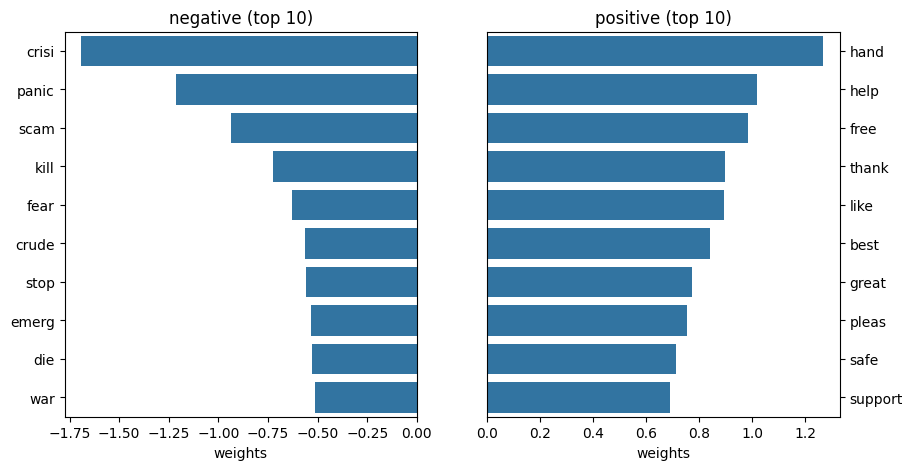

In [37]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
train_vecs = scaler.fit_transform(X_cv_df_train)
test_vecs = scaler.transform(X_cv_df_test)

clf = LogisticRegression().fit(train_vecs, y_train)
accuracy_train, accuracy_test = accuracy_score(y_train, clf.predict(train_vecs)), accuracy_score(y_test, clf.predict(test_vecs))
print(f'accuracy train: {accuracy_train} ; test: {accuracy_test}')

weights = clf.coef_[0]
names = cv_df.get_feature_names_out()
df_w = pd.DataFrame({'names': names, 'weights': weights})
sorted_pos = pd.DataFrame({'names': names, 'weights': weights}).sort_values('weights', ascending = False).head(10)
sorted_neg = pd.DataFrame({'names': names, 'weights': weights}).sort_values('weights', ascending = True).head(10)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches((10, 5))
sns.barplot(ax=ax2, data=sorted_pos, y="names", x="weights", orient="y")
sns.barplot(ax=ax1, data=sorted_neg, y="names", x="weights", orient="y")
ax2.set_ylabel("")
ax1.set_ylabel("")
ax2.set_title("positive (top 10)")
ax1.set_title("negative (top 10)")
ax2.yaxis.set_ticks_position('right')
plt.show()

**Ответ:** Качество практически не зменилось, а токены неплохие, они эмоционально окрашены и с ними можно работать

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [38]:
print(df.shape[0], df['UserName'].nunique(), df['ScreenName'].nunique())

33444 33444 33444


**Ответ:** Они бесполезны, так как все уникальны

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на основе целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

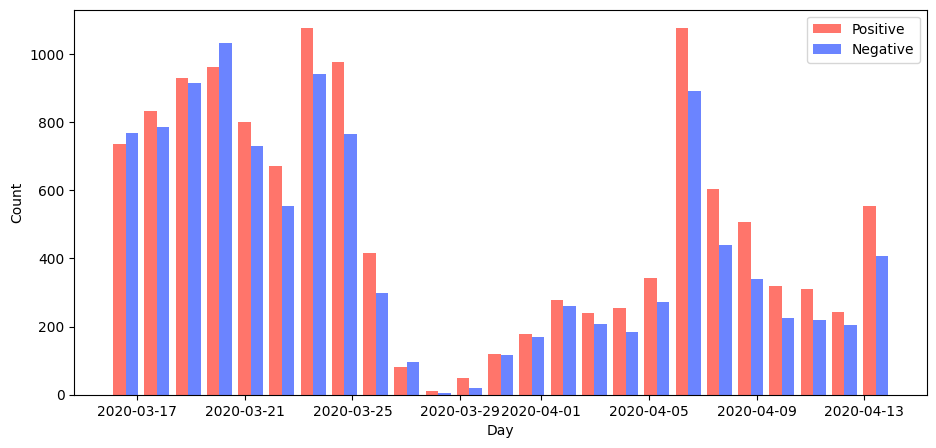

In [39]:
train['TweetAt'] = pd.to_datetime(train['TweetAt'], format='%d-%m-%Y')
plt.figure(figsize=(11, 5))
plt.hist([train[train['Sentiment'] == 1]['TweetAt'], train[train['Sentiment'] == 0]['TweetAt']], bins = 25, color = ['#ff756b', '#6b84ff'], label=['Positive', 'Negative'])
plt.legend()
plt.ylabel("Count")
plt.xlabel("Day")
plt.show()

**Ответ:** Признак бесполезен, так как соотношение позитивных и негативных твитов постоянно.



Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [40]:
train['Location'].nunique()

7949

Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

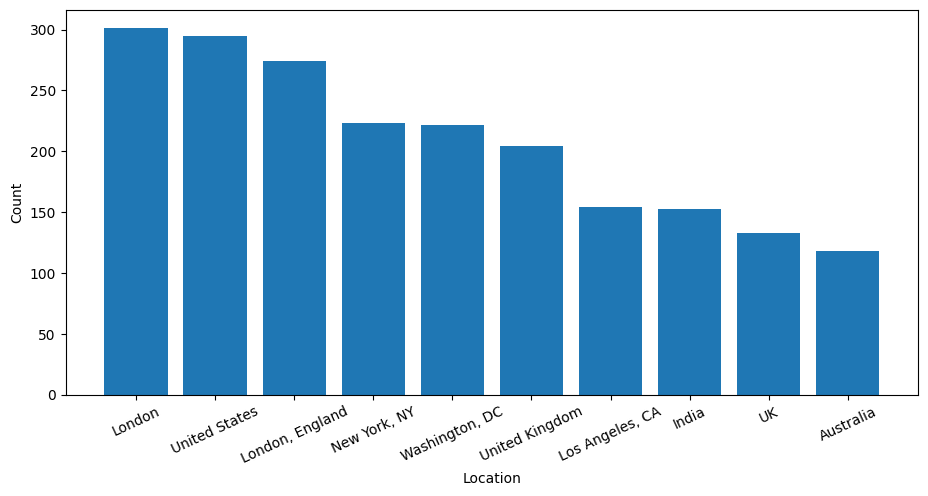

In [41]:
plt.figure(figsize=(11, 5))
plt.bar(train['Location'].value_counts()[1:11].index, train['Location'].value_counts()[1:11].values)
plt.xlabel('Location')
plt.ylabel('Count')
plt.xticks(rotation=25)
plt.show()

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

4915


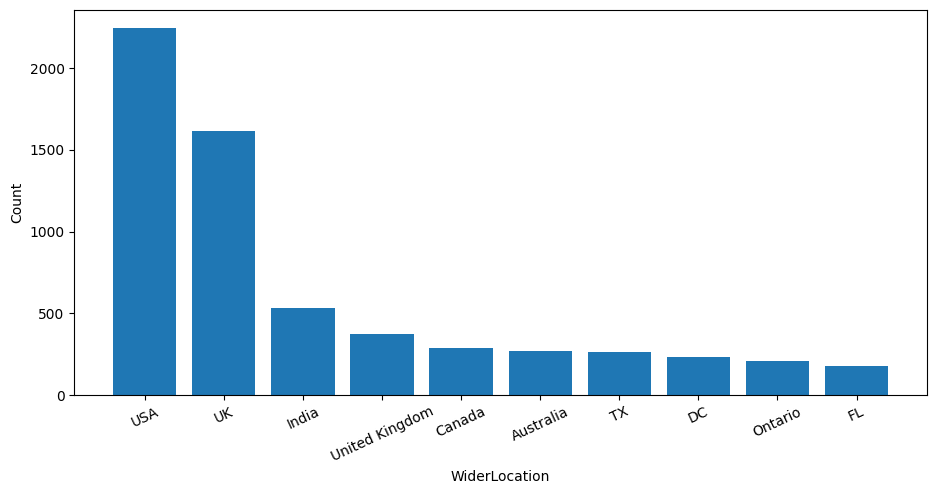

In [42]:
def wider(word):
  words = {'England': 'UK', 'CA': 'USA', 'NY': 'USA', 'London': 'UK', 'United States': 'USA', 'United Kindom': 'UK'}
  if word in words.keys(): return words[word]
  return word

train['WiderLocation'] = train['Location'].apply(lambda x: wider(x.split(", ")[-1]))
test['WiderLocation'] = test['Location'].apply(lambda x: wider(x.split(", ")[-1]))
print(train['WiderLocation'].nunique())
plt.figure(figsize=(11, 5))
plt.bar(train['WiderLocation'].value_counts()[1:11].index, train['WiderLocation'].value_counts()[1:11].values)
plt.xlabel('WiderLocation')
plt.ylabel('Count')
plt.xticks(rotation=25)
plt.show()

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [43]:
from sklearn.preprocessing import OneHotEncoder
categs = train['WiderLocation'].value_counts()
categs_ = (categs[categs > 1]).keys()
encoder = OneHotEncoder(sparse_output=True, handle_unknown='ignore', categories=[categs_])
train_enc = encoder.fit_transform(train[['WiderLocation']])
test_enc = encoder.transform(test[['WiderLocation']])

Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [49]:
X_cv_train

array([<Compressed Sparse Row sparse matrix of dtype 'int64'
       	with 438571 stored elements and shape (23410, 36623)>,
       <Compressed Sparse Row sparse matrix of dtype 'float64'
       	with 19500 stored elements and shape (23410, 1005)>   ],
      dtype=object)

In [51]:
from scipy.sparse import hstack
y_train = train['Sentiment']
y_test = test['Sentiment']

X_cv_train = hstack((cv.fit_transform(train['OriginalTweet'].values), train_enc))
X_tfitv_train = hstack((tfid.fit_transform(train['OriginalTweet'].values), train_enc))

X_cv_test = hstack((cv.transform(test['OriginalTweet'].values), test_enc))
X_tfitv_test = hstack((tfid.transform(test['OriginalTweet'].values), test_enc))

clf = LogisticRegression().fit(X_cv_train, y_train)
clf_tfid = LogisticRegression().fit(X_tfitv_train, y_train)

y_pred_cv_train, y_pred_cv_test = clf.predict(X_cv_train), clf.predict(X_cv_test)
y_pred_tfitv_train, y_pred_tfitv_test = clf_tfid.predict(X_tfitv_train), clf_tfid.predict(X_tfitv_test)
acuracy_cv_train, accuracy_cv_test = accuracy_score(y_train, y_pred_cv_train), accuracy_score(y_test, y_pred_cv_test)
acuracy_tfitv_train, accuracy_tfitv_test = accuracy_score(y_train, y_pred_tfitv_train), accuracy_score(y_test, y_pred_tfitv_test)
print(f'accuracy train cv: {acuracy_cv_train} ; tfitv: {acuracy_tfitv_train}')
print(f'accuracy test cv: {accuracy_cv_test} ; tfitv: {accuracy_tfitv_test}')

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


accuracy train cv: 0.9717642033319095 ; tfitv: 0.920333190944041
accuracy test cv: 0.864959138927646 ; tfitv: 0.8533984452860275


**Ответ:** Accuracy чуть-чуть повысился, поэтому можно сказать, что этот признак дает полезную информацию, однако не прям-таки значительную